# MTTN to MSN
## Input: Multilayer temporal text network created in file 'ttn_to_mttn'
## Output: Various multilayer social networks, where layers represents social dimensions and sentiment

In [50]:
import uunet.multinet as ml
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

In [24]:
def initialise_net(actors, directed, layers):
    '''
    creates empty persons network
    '''
    persons_10d = ml.empty()
    ml.add_layers(persons_10d, layers, directed=[directed])

    # add persons as vertices and attributes
    for layer in layers:
        
        actor_vertices = {"actor": actors, "layer": [layer]*len(actors)}
        ml.add_vertices(persons_10d, actor_vertices)
        ml.add_attributes(persons_10d, ["tidslinje"], target= "edge", layer=layer, type="string")
        ml.add_attributes(persons_10d, ["w_","neutral","negative","positive","sentiment-score"], target = "edge", layer = layer, type="numeric")
        
    return persons_10d


def get_receivers(ttn_10d, sent_messages, only_addressed):
    '''
    get receivers of sent messages
    '''

    # vertices
    sent_vertices = {"actor": sent_messages, "layer": ['messages']*len(sent_messages)}

    # received by
    addressed = ml.get_values(ttn_10d, "addressed", vertices=sent_vertices)['addressed']

    if only_addressed:
        received_by = addressed
    else:
        not_addressed  = ml.get_values(ttn_10d, "not_addressed", vertices=sent_vertices)['not_addressed']
        received_by = addressed + not_addressed

    # filter out '-' and split on ','
    received_by = [r.split(',') for r in received_by if r != '-']

    # flatten list of lists to one list 
    received_by = list(itertools.chain.from_iterable(received_by))

    return received_by

def add_weights(actor,persons_10d,received_by, layer):
    '''
    add weights
    '''
    # loop all persons reached by senders messages (duplicated included, important to use duplicates!)
    for receiver in received_by:
        # set actor-receiver edge
        edge = {"from_actor": [actor], "from_layer": [layer], 
                 "to_actor": [receiver], "to_layer": [layer]}
        
        # get weight for edge
        weight = ml.get_values(persons_10d, "w_", edges = edge)['w_'][0]
    
        # increase weight
        if weight == None:
            weight = 1
        else:
            weight += 1
    
        # set weight
        ml.set_values(persons_10d, "w_", edges = edge, values = [weight])

def add_sentiment(actor, ttn_10d, persons_10d, sent_messages, received_by):
    '''
    increase sentiment-count for each message 
    '''

    # go through all sent messages 
    for message in sent_messages:

            # sent message vertice
            message_vertice = message_vertice = {"actor": [message], "layer": ['messages']}

            # get sentiment label of sent messasge 
            sentiment_label = ml.get_values(ttn_10d, "sentiment-label", vertices = message_vertice)['sentiment-label'][0]

            # get receivers of message
            received_by = get_receivers(ttn_10d, [message], only_addressed) 

            # increasse sentiment count for edges between actor and receivers
            for receiver in received_by:
                
                # get edge
                edge = {"from_actor": [actor], "from_layer": [layer], 
                     "to_actor": [receiver], "to_layer": [layer]}
                
                # get edge count for sentiment-label
                label_count = ml.get_values(persons_10d, sentiment_label, edges = edge)[sentiment_label][0]

                # increase sentiment-label count
                if label_count == None:
                    label_count = 1
                else:
                    label_count += 1
                 
                # set sentiment-label count
                ml.set_values(persons_10d, sentiment_label, edges = edge, values = [label_count])

                # get edge count for all sentiment-labels
                negative_count = ml.get_values(persons_10d, 'negative', edges = edge)['negative'][0]
                positive_count = ml.get_values(persons_10d, 'positive', edges = edge)['positive'][0]
                neutral_count = ml.get_values(persons_10d, 'neutral', edges = edge)['neutral'][0]

                if negative_count == None:
                    negative_count = 0
                    ml.set_values(persons_10d, 'negative', edges = edge, values = [negative_count])
                if positive_count == None:
                    positive_count = 0
                    ml.set_values(persons_10d, 'positive', edges = edge, values = [positive_count])
                if neutral_count == None:
                    neutral_count = 0
                    ml.set_values(persons_10d, 'neutral', edges = edge, values = [neutral_count])
                    
                # get total sentiment-label count
                tot_count = ml.get_values(persons_10d, "w_", edges = edge)['w_'][0]

                # calc sentiment score
                try:
                    sentiment_score = (positive_count-negative_count)/tot_count
                except:
                    sentiment_score = 0
                    
                # set score
                ml.set_values(persons_10d, 'sentiment-score', edges = edge, values = [sentiment_score])

def add_time(actor, ttn_10d, persons_10d, sent_messages, received_by):
    '''
    add timestamp to timeline on edges
    '''
    
    # go through all sent messages 
    for message in sent_messages:

            # sent message vertice
            message_vertice = message_vertice = {"actor": [message], "layer": ['messages']}

            # get start time of sent messasge 
            start_time = ml.get_values(ttn_10d, "start", vertices = message_vertice)['start'][0]

            # get receivers of message
            received_by = get_receivers(ttn_10d, [message], only_addressed) 

            # add timestamp to timeline for edges between actor and receivers
            for receiver in received_by:
                
                # get edge
                edge = {"from_actor": [actor], "from_layer": [layer], 
                     "to_actor": [receiver], "to_layer": [layer]}
                
                # get timeline for edge
                timeline = ml.get_values(persons_10d, 'tidslinje', edges = edge)['tidslinje'][0]

                # add timestamp to timeline
                if timeline == None:
                    timeline = str(start_time)
                else:
                    timeline += f',{str(start_time)}'
                 
                # set timeline
                ml.set_values(persons_10d, 'tidslinje', edges = edge, values = [timeline])


def project(ttn_10d, actors, persons_10d, layer_edges, layer, directed, only_addressed):
    '''
    projects one dimension
    '''
    
    # fill person network
    for actor in actors:
        
        # get messages sent by actor
        sent_messages = layer_edges.loc[layer_edges['from_actor'] == actor]['to_actor']

        # skip loop if there is no messages sent by actor in layer
        if len(sent_messages) == 0:
            continue
            
        # get who receives the messages sent by actor
        received_by = get_receivers(ttn_10d, sent_messages, only_addressed) 

        # skip loop if there are no receivers
        if len(received_by) == 0:
            continue
        
        # add edges between actor and receivers
        edges = {"from_actor": [actor]*len(received_by), "from_layer": [layer]*len(received_by), 
                 "to_actor": received_by, "to_layer": [layer]*len(received_by)}
        
        # add edges
        ml.add_edges(persons_10d, edges) 

        # add weights
        add_weights(actor,persons_10d,received_by,layer)

        # add time
        add_time(actor, ttn_10d, persons_10d, sent_messages, received_by)

        # add sentiment
        add_sentiment(actor, ttn_10d, persons_10d, sent_messages, received_by)
    

In [39]:
#main

# network types
net_types = [{'directed':True, 'only_addressed':True},{'directed':True, 'only_addressed':False},
            {'directed':False, 'only_addressed':True},{'directed':False, 'only_addressed':False}] # specify which types of networks that will be created


# load ttn
ttn_10d = ml.read('data/ttn_nets/mttn.txt')

# get layers to project from
layers = ml.layers(ttn_10d)
layers.remove('persons')

for net_type in net_types:

    # unpack type
    directed = net_type['directed']
    only_addressed = net_type['only_addressed']
    
    # get all person actors
    actors = ml.vertices(ttn_10d, layers=['persons'])['actor']

    # initialise persons net
    persons_10d = initialise_net(actors, directed, layers)

    # fill each layer
    for layer in layers:
        
        # get edges from original 10d-ttn
        layer_edges = ml.edges(ttn_10d, layers1=['persons',layer])
        layer_edges = pd.DataFrame.from_dict(layer_edges)
        
        # project 
        project(ttn_10d, actors, persons_10d, layer_edges, layer, directed, only_addressed)

    # name of net
    name = f'msn'
    if directed:
        name = name + '_directed'
    else:
        name = name + '_undirected'
    if only_addressed:
        name = name + '_addressed'
    else:
        name = name + '_everyone'

    save_path = f'data/multilayer_social_networks/{name}'
    print(f'{name}:')
    display(pd.DataFrame.from_dict(ml.summary(persons_10d)))
    ml.write(n = persons_10d,file = save_path+'.graphml', format = "graphml")
    ml.write(n = persons_10d,file = save_path+'.txt', format = "multilayer")


msn_directed_addressed:


,layer,n,m,dir,nc,slc,dens,cc,apl,dia
0,romance,124,35,True,115,10,0.002295,0.046875,2.444444,5
1,knowledge,124,58,True,115,10,0.003803,0.034483,2.000000,3
2,negative,124,95,True,97,25,0.006229,0.138889,2.448333,5
3,messages,124,244,True,66,57,0.015998,0.097394,2.523810,5
4,power,124,34,True,120,5,0.002229,0.115385,1.450000,2
5,identity,124,0,True,124,1,0.000000,0.000000,0.000000,0
6,status,124,37,True,118,6,0.002426,0.016949,2.233333,5
7,conflict,124,51,True,113,12,0.003344,0.164773,2.121212,5
8,support,124,57,True,107,18,0.003737,0.066667,2.330065,4
9,positive,124,111,True,104,21,0.007278,0.059229,2.309524,4


msn_directed_everyone:


,layer,n,m,dir,nc,slc,dens,cc,apl,dia
0,romance,124,88,True,111,14,0.005770,0.079399,2.076923,4
1,negative,124,229,True,90,35,0.015014,0.192459,2.300840,4
2,messages,124,533,True,55,66,0.034946,0.299412,2.217483,4
3,power,124,84,True,116,9,0.005507,0.054381,2.027778,4
4,conflict,124,131,True,105,20,0.008589,0.139423,2.297368,5
5,knowledge,124,108,True,110,14,0.007081,0.077488,2.109890,4
6,identity,124,0,True,124,1,0.000000,0.000000,0.000000,0
7,neutral,124,378,True,73,50,0.024784,0.215094,2.227347,4
8,status,124,81,True,116,7,0.005311,0.099010,2.285714,6
9,fun,124,54,True,119,3,0.003541,0.129371,1.333333,2


msn_undirected_addressed:


,layer,n,m,dir,nc,slc,dens,cc,apl,dia
0,negative,124,67,False,78,46,0.008786,0.143713,2.652174,5
1,romance,124,30,False,99,24,0.003934,0.107914,2.485507,5
2,knowledge,124,51,False,81,42,0.006688,0.069409,2.577236,4
3,messages,124,165,False,20,94,0.021637,0.108502,2.707390,6
4,conflict,124,41,False,93,31,0.005376,0.166667,2.559140,4
5,power,124,29,False,97,26,0.003803,0.080000,3.403077,8
6,status,124,35,False,93,26,0.004590,0.048913,2.458462,5
7,identity,124,0,False,124,1,0.000000,0.000000,0.000000,0
8,fun,124,15,False,109,13,0.001967,0.000000,2.564103,4
9,support,124,41,False,90,33,0.005376,0.078652,2.636364,5


msn_undirected_everyone:


,layer,n,m,dir,nc,slc,dens,cc,apl,dia
0,knowledge,124,94,False,65,60,0.012326,0.157051,2.544068,4
1,negative,124,175,False,53,72,0.022948,0.286236,2.566901,5
2,messages,124,366,False,1,124,0.047994,0.267956,2.562025,7
3,romance,124,74,False,77,48,0.009704,0.158909,2.597518,5
4,identity,124,0,False,124,1,0.000000,0.000000,0.000000,0
5,status,124,76,False,72,53,0.009966,0.116505,2.783745,6
6,support,124,90,False,67,58,0.011802,0.133106,2.630369,5
7,conflict,124,108,False,71,54,0.014162,0.237342,2.538784,5
8,power,124,77,False,68,56,0.010097,0.097649,2.946104,7
9,fun,124,49,False,94,27,0.006425,0.303965,2.444444,4


In [40]:
edge = {"from_actor": ['Valjean'], "from_layer": ['messages'], 
         "to_actor": ['Javert'], "to_layer": ['messages']}

# get weight for edge
timeline = ml.get_values(persons_10d, "tidslinje", edges = edge)['tidslinje'][0]
weight = ml.get_values(persons_10d, "w_", edges = edge)['w_'][0]
timeline = timeline.split(',')
print(len(timeline))
print(weight)

141
141.0


In [65]:
net = ml.read('data/multilayer_social_networks/msn_undirected_addressed.txt')


df = pd.DataFrame.from_dict(ml.summary(net))

df = df[~df["layer"].isin(["positive","negative","neutral"])]
df = df.drop(columns=["dir"])

df = df.rename(columns={"n": "nodes", "m": "edges"})

df = df.sort_values("edges", ascending=False)

df["layer"] = ["As_all", "As_trust","As_conflict","As_knowledge","As_support","As_power","As_status","As_romance","As_fun","As_similarity","As_identity"]

df = df.sort_values("layer", ascending=False)

df = df.reset_index()

df = df.drop(columns=["index"])

display(df)
#df.to_excel('summary.xlsx', engine='xlsxwriter')  


,layer,nodes,edges,nc,slc,dens,cc,apl,dia
0,As_trust,124,53,84,40,0.006950,0.148026,2.844872,6
1,As_support,124,41,90,33,0.005376,0.078652,2.636364,5
2,As_status,124,30,99,24,0.003934,0.107914,2.485507,5
3,As_similarity,124,10,115,6,0.001311,0.250000,1.866667,3
4,As_romance,124,29,97,26,0.003803,0.080000,3.403077,8
5,As_power,124,35,93,26,0.004590,0.048913,2.458462,5
6,As_knowledge,124,41,93,31,0.005376,0.166667,2.559140,4
7,As_identity,124,0,124,1,0.000000,0.000000,0.000000,0
8,As_fun,124,15,109,13,0.001967,0.000000,2.564103,4
9,As_conflict,124,51,81,42,0.006688,0.069409,2.577236,4


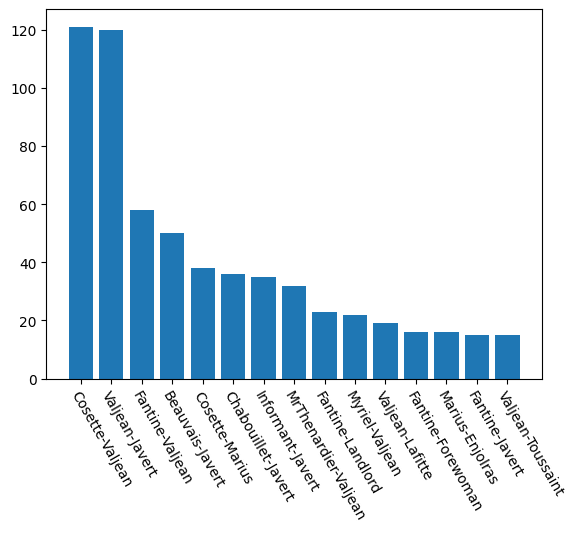

In [42]:
actors = ml.actors(net,layers=["messages"])["actor"]

edges = []
weights = []
for i, actor1 in enumerate(actors):
    for actor2 in actors[i:]:
        edge = {"from_actor": [actor1], "from_layer": ["messages"], 
                         "to_actor": [actor2], "to_layer": ["messages"]}
        try:
            weight = ml.get_values(net, "w_", edges = edge)['w_'][0]
            weights.append(weight)
            edges.append(f'{actor1}-{actor2}')
        except:
            pass

x = [e for e, _ in sorted(zip(edges, weights), reverse=True, key=lambda pair: pair[1])]

y = sorted(weights, reverse=True) 

n = 15

plt.bar(x[:n],y[:n])
plt.xticks(rotation = -60, ha="left", rotation_mode="anchor")
print()


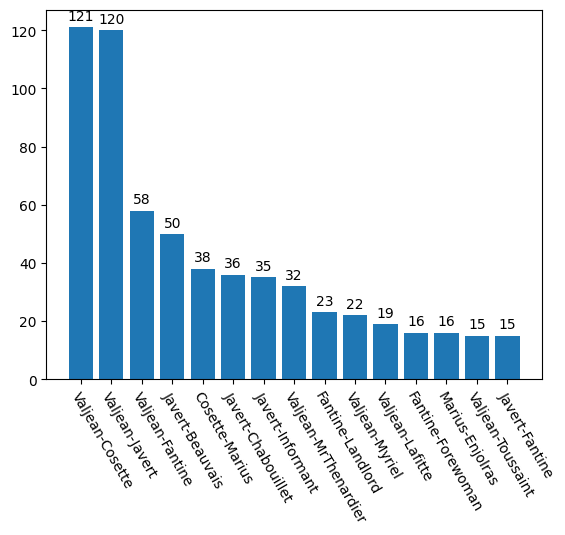

In [43]:
actors = ml.actors(net,layers=["messages"])["actor"]

actors = ["Valjean", "Javert", "Cosette", "Fantine", "Beauvais", "Marius", "Chabouillet", "MrThenardier", "Informant", "Landlord", "Myriel", "Lafitte", "Forewoman", "Enjolras","Toussaint"]
edges = []
weights = []
for i, actor1 in enumerate(actors):
    for actor2 in actors[i:]:
        edge = {"from_actor": [actor1], "from_layer": ["messages"], 
                         "to_actor": [actor2], "to_layer": ["messages"]}
        try:
            weight = ml.get_values(net, "w_", edges = edge)['w_'][0]
            weights.append(weight)
            edges.append(f'{actor1}-{actor2}')
        except:
            pass

x = [e for e, _ in sorted(zip(edges, weights), reverse=True, key=lambda pair: pair[1])]

y = sorted(weights, reverse=True) 


fig, ax = plt.subplots()


n = 15

p = ax.bar(x[:n],y[:n])
ax.bar_label(p, padding=3)
ax.set_xticks(x[:n], labels=x[:n], rotation=-60,  ha="left", rotation_mode="anchor")
print()



In [44]:
def edge_dist(net,p1,p2,dimensions):

    dist = {}

    for dim in dimensions:
        edge = {"from_actor": [p1], "from_layer": [dim], "to_actor": [p2], "to_layer": [dim]}
        try:
            weight = ml.get_values(net, "w_", edges = edge)['w_'][0]
        except:
            weight = 0
            
        dist[dim] = weight

    return dist
        

C:\Users\Asus\AppData\Local\Temp\ipykernel_24600\2606441882.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append([distribution1, distribution2], ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_24600\2606441882.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append([distribution1, distribution2], ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_24600\2606441882.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-

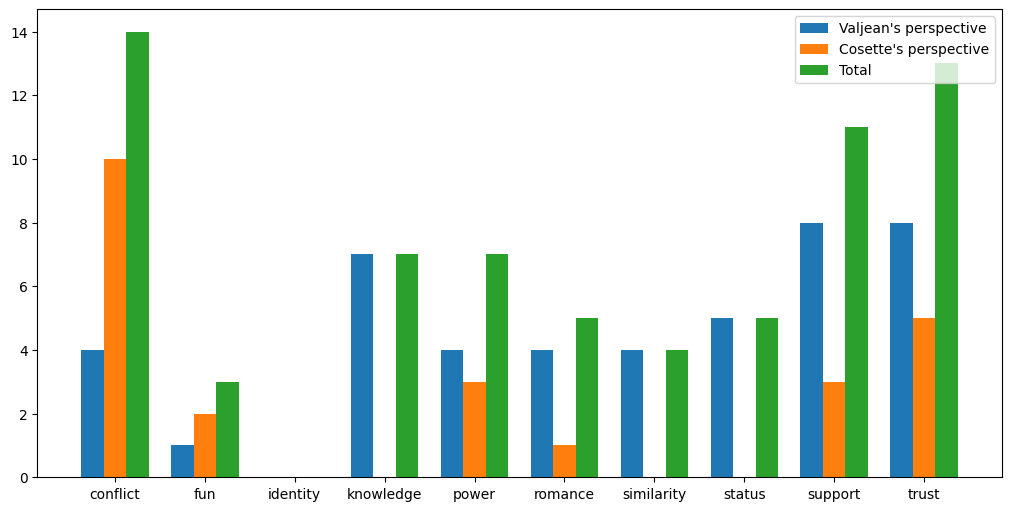

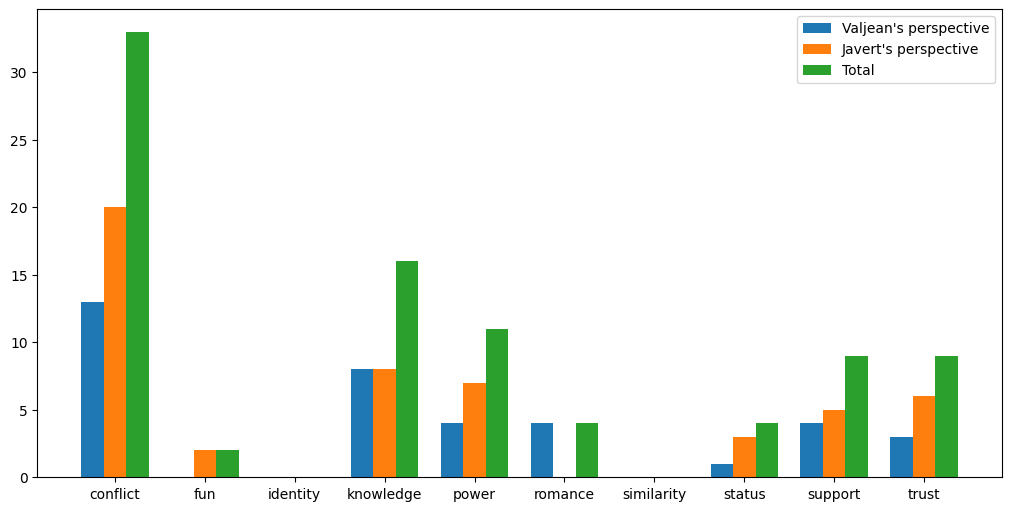

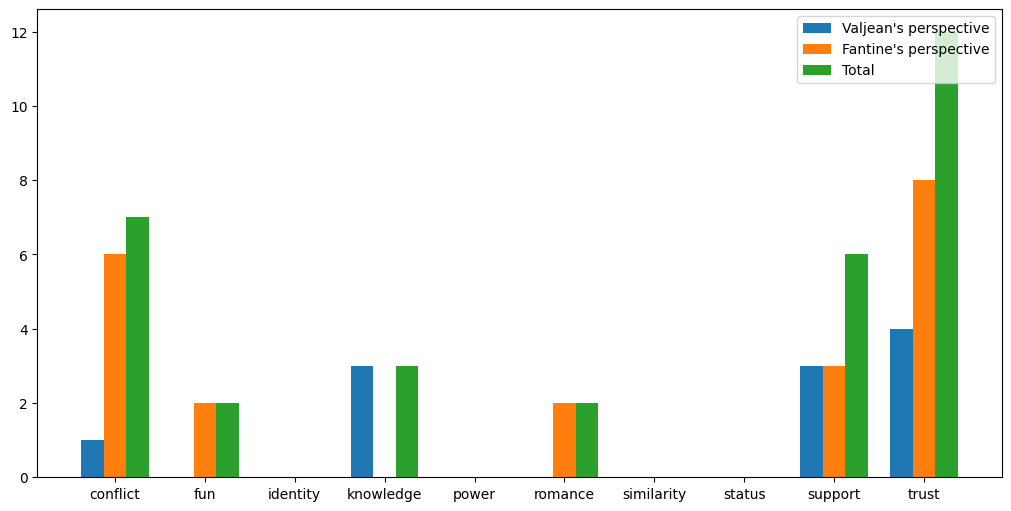

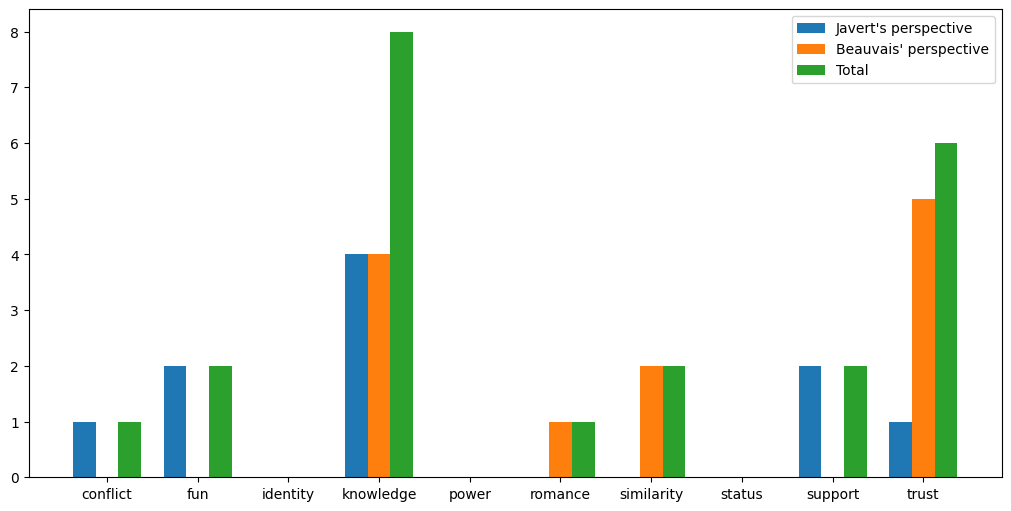

In [62]:
net = ml.read('data/multilayer_social_networks/msn_directed_addressed.txt')
edges = [('Valjean','Cosette'),('Valjean','Javert'),('Valjean','Fantine'),('Javert','Beauvais')]

dimensions = ['support', 'fun', 'power', 'knowledge', 'similarity', 'conflict', 'romance', 'trust', 'status', 'identity']

dimensions = sorted(dimensions)
for p1,p2 in edges:

    # get distributions
    distribution1 = edge_dist(net,p1,p2,dimensions) 
    distribution2 = edge_dist(net,p2,p1,dimensions)

    # make dataframes
    df = pd.DataFrame(columns=dimensions)
    df = df._append([distribution1, distribution2], ignore_index=True)
    df['edge'] = [f'{p1}-->{p2}',f'{p2}-->{p1}']

    # barplot plot
    
    edge1 = df.iloc[0]['edge']
    edge2 = df.iloc[1]['edge']
    edge3 = f'Total'
    
    values1 = df.iloc[0].values.tolist()[:-1]
    values2 = df.iloc[1].values.tolist()[:-1]
    values3 = [w1 + w2 for w1,w2 in zip(values1, values2)]

    edge_weights = {
        edge1: values1,
        edge2: values2,
        edge3: values3,
    }
    
    x = np.arange(len(dimensions))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
    
    for key in edge_weights:
        try:
            i = key.index('-')
            if key[i-1] == 's':
                label = f"{key[:i]}' perspective"
            else:
                label = f"{key[:i]}'s perspective"
        except:
            label = key
        
        offset = width * multiplier
        rects = ax.bar(x + offset, edge_weights[key], width, label=label)
        #ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('Message count')
    # ax.set_xlabel('Dimension')
    ax.set_xticks(x + width, dimensions)
    ax.legend(loc='upper right')
   # plt.show()

In [56]:
def get_time_line(net, from_node, to_node, end_min, dimensions):
    
    
    time_line = {dim:[]for dim in dimensions}


    for dim in dimensions: 

        edge = {"from_actor": [from_node], "from_layer": [dim], "to_actor": [to_node], "to_layer": [dim]}
        try:
            tidslinje = ml.get_values(net, "tidslinje", edges = edge)['tidslinje'][0]
            tidslinje = tidslinje.split(",")
            time_stamps = [round(float(t)/60,0) for t in tidslinje]                     
        except Exception as e:
            time_stamps = []

        count = 0
        for t in range(end_min):
            for t1 in time_stamps: 
                if t == t1:
                    count += 1
            time_line[dim].append((t,count))
             
    return time_line


def plot_timeline_heatmap(timeline,ax, dimensions, edge, cmap):
    timeline_2d = []

    for dim in dimensions:
        row = [c for _,c in timeline[dim]]
        timeline_2d.append(row)
    #sns.heatmap(timeline_2d,ax=ax, yticklabels=dimensions,cmap=mpl.colormaps[cmap], linewidths=0)
    
    sns.heatmap(timeline_2d,ax=ax, yticklabels=dimensions,cmap=mpl.colormaps[cmap], linewidths=0)
    ax.set_title(edge)
    #ax.set_xlabel('minute')
    ax.tick_params(axis='x', labelrotation=-60)

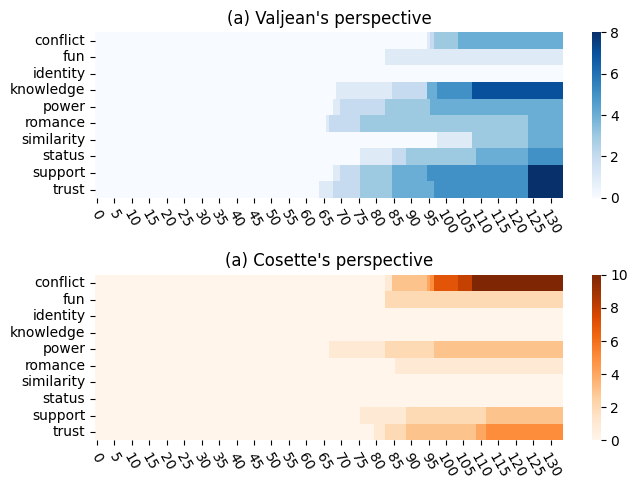

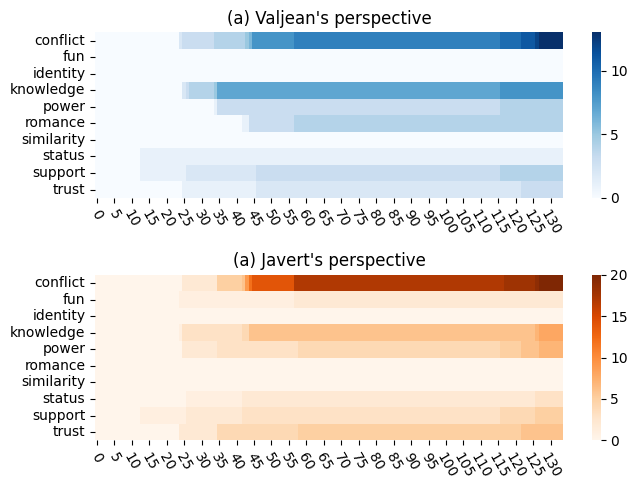

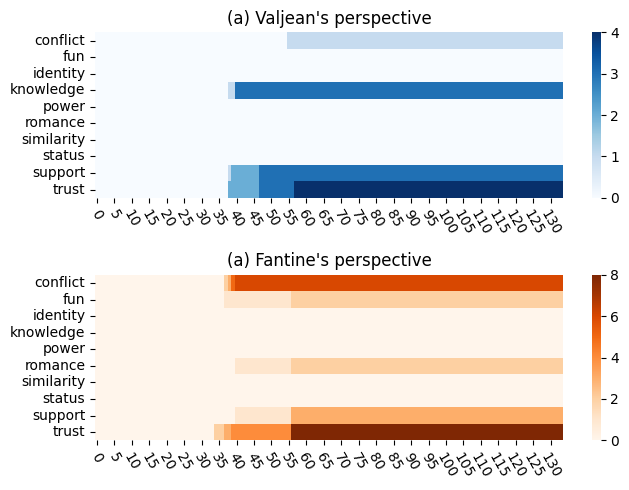

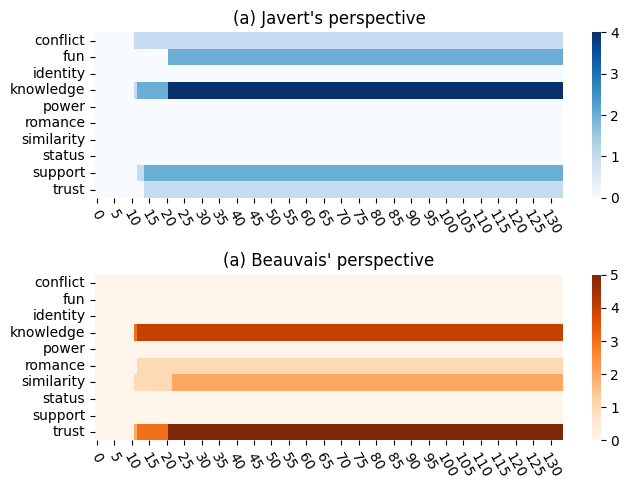

In [63]:
for p1,p2 in edges:
    
    # get timelines
    movie_length = 134
    timeline1 = get_time_line(net,p1,p2,movie_length,dimensions)
    timeline2 = get_time_line(net,p2,p1,movie_length,dimensions)

    # heatmap
    fig, axes = plt.subplots(2,1, figsize=(7,5))
    #fig.suptitle('Timeline')


    if p1[-1] == 's':
        title1 = f"(a) {p1}' perspective"
    else:
        title1 = f"(a) {p1}'s perspective"
        
    plot_timeline_heatmap(timeline1,axes[0],dimensions, title1, 'Blues')

    if p2[-1] == 's':
        title2 = f"(a) {p2}' perspective"
    else:
        title2 = f"(a) {p2}'s perspective"
    plot_timeline_heatmap(timeline2,axes[1],dimensions, title2, 'Oranges')
    fig.tight_layout()
